SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #8: Time Series Forecasting with ML </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - demand forecasting, lagged features, time series CV

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

# Demand Time Series

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityWAPE, qualityRMSE
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

In [153]:
# ! pip install --upgrade Cython
# ! pip install --upgrade git+https://github.com/statsmodels/statsmodels
import statsmodels.api as sm

In [154]:
# загружаем данные
ts_retail = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv', sep=';')
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], dayfirst = True)
ts_retail.set_index(['Date'], inplace=True)
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22,163.78,NaN
2015-01-02,1,1,NaN,41,163.78,NaN
2015-01-03,1,1,NaN,35,163.78,NaN
2015-01-04,1,1,NaN,72,163.78,NaN
2015-01-05,1,1,NaN,25,163.78,NaN


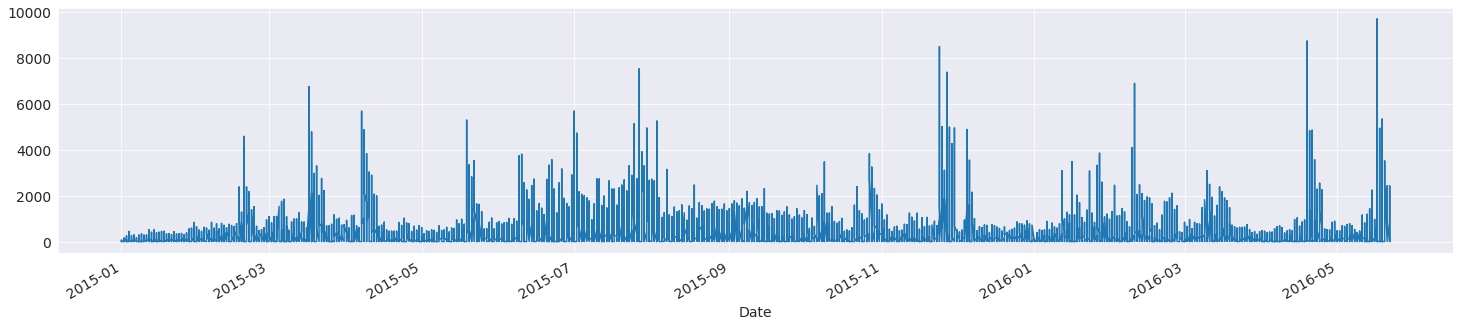

In [155]:
ts_retail['Demand'].plot()

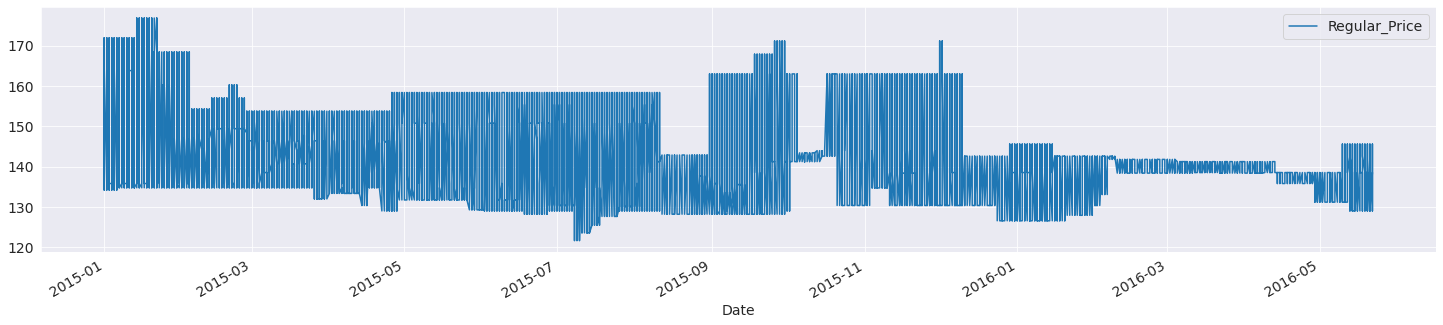

<Figure size 1800x360 with 0 Axes>

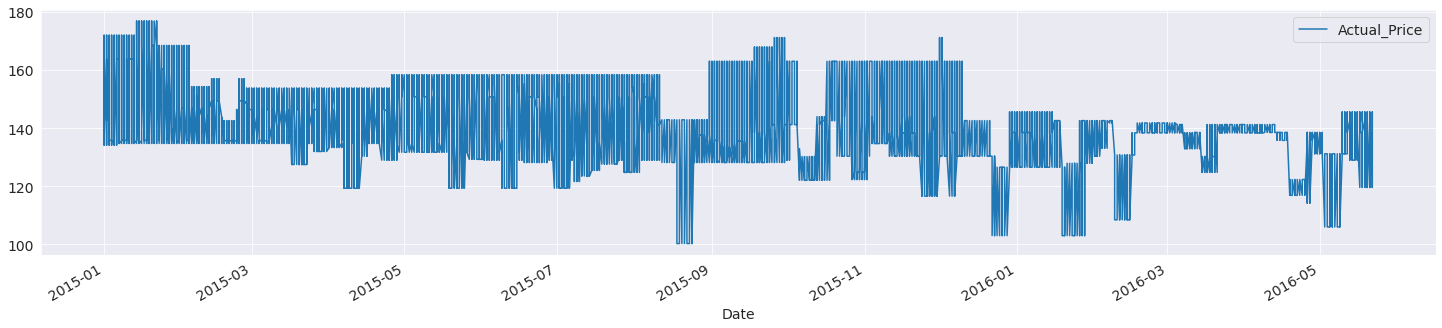

In [160]:
# Fill missings  (note: step is domain specific)
ts_retail['Promo'] = ts_retail['Promo'].fillna(0)
ts_retail['Regular_Price'] = ts_retail['Regular_Price'].ffill().bfill()
ts_retail[['Regular_Price']].plot()

# Add actual price (promo price when promo occurred or regular price otherwise)
plt.figure()
ts_retail['Actual_Price'] = ts_retail.Promo_Price.combine_first(ts_retail.Regular_Price) 
ts_retail[['Actual_Price']].plot()

In [ ]:
# prepare test/train datasets
train = ts_retail.loc[:'01-05-2016']
test = ts_retail.loc['01-05-2016':]
test_y = test[['Store_id', 'SKU_id', 'Demand']]
test['Demand'] = np.NaN
test = pd.concat([train, test], axis=0, sort=False, ignore_index=True)

train.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price
Date,,,,,,,
2015-01-01,1,1,0.0,22,163.78,NaN,163.78
2015-01-02,1,1,0.0,41,163.78,NaN,163.78
2015-01-03,1,1,0.0,35,163.78,NaN,163.78
2015-01-04,1,1,0.0,72,163.78,NaN,163.78
2015-01-05,1,1,0.0,25,163.78,NaN,163.78


In [ ]:
test.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price
Date,,,,,,,
2016-01-05,1,1,0.0,NaN,126.54,NaN,126.54
2016-01-06,1,1,0.0,NaN,126.54,NaN,126.54
2016-01-07,1,1,0.0,NaN,126.54,NaN,126.54
2016-01-08,1,1,0.0,NaN,126.54,NaN,126.54
2016-01-09,1,1,0.0,NaN,126.54,NaN,126.54


In [ ]:
sales_by_sku.head()

,SKU_id,Demand,Promo,Store_id,Actual_Price
Date,,,,,
2015-01-01,1,1180,0.0,73,163.920685
2015-01-02,1,3667,0.0,73,163.920685
2015-01-03,1,4987,0.0,73,163.920685
2015-01-04,1,5226,0.0,73,163.920685
2015-01-05,1,5951,0.0,73,163.920685


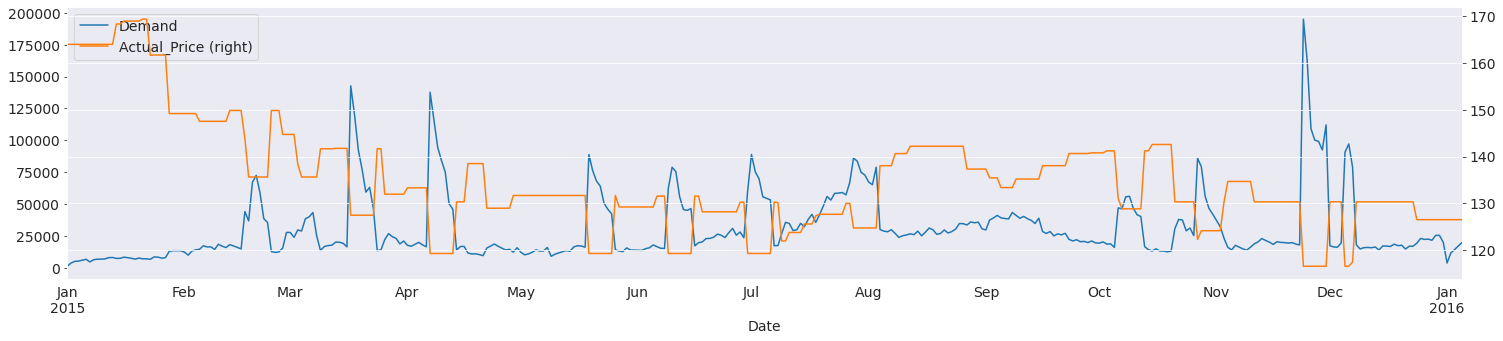

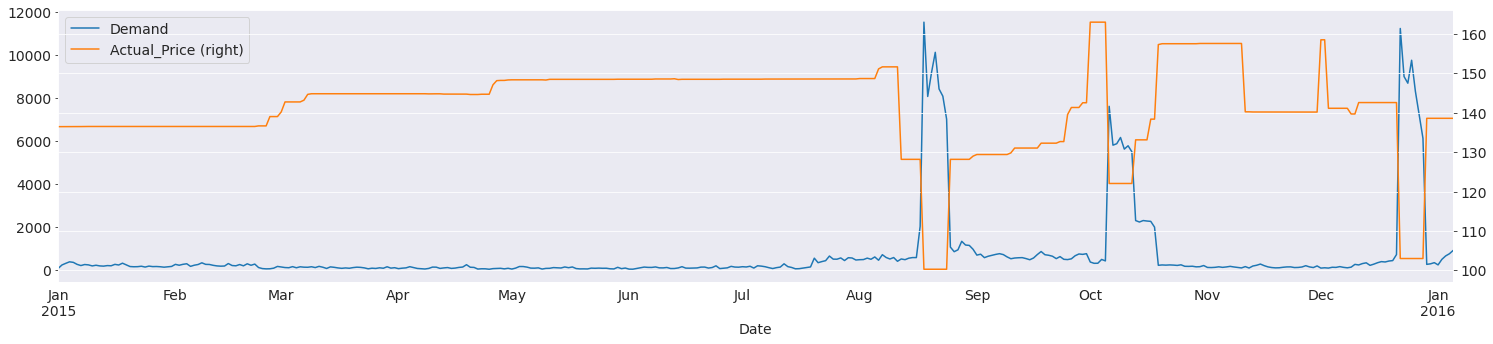

In [ ]:
# Aggregate on Sku - All Stores level
sales_by_sku = train.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Actual_Price':'mean'}).reset_index().set_index('Date')
sales_by_sku[sales_by_sku['SKU_id'] == 1][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

sales_by_sku[sales_by_sku['SKU_id'] == 2][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])
# sales_by_sku[['Actual_Price']].plot(secondary_y = True)

# ML for time series Forecasting

**Questions**
* Can classic ML algorithms (including DT regressor, Boosting, RF regressors)   be applied to the ts forecasting problem?
  - Yes, assuming that ts model is defined properly

* How CV should be organized for ts problem?

<img src = 'https://miro.medium.com/max/753/1*qvdnPF8ETV9mFdMT0Y_BBA.png'>

## Feature generation for ML algorithms
**Questions**
* What features should be added to the original data set?
   - Calendar-dummy variables: holidays, day of week, day of month
   - Lagged-features
   - x-sindicated features (e.g price x store_number**2)

In [161]:
# feature generation
data = sales_by_sku.reset_index().copy(deep = True)

data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,Date,SKU_id,Demand,Promo,Store_id,Actual_Price,weekday,monthday,is_weekend
0,2015-01-01,1,1180,0.0,73,163.920685,3,1,0
1,2015-01-02,1,3667,0.0,73,163.920685,4,2,0
2,2015-01-03,1,4987,0.0,73,163.920685,5,3,1
3,2015-01-04,1,5226,0.0,73,163.920685,6,4,1
4,2015-01-05,1,5951,0.0,73,163.920685,0,5,0


### Lagged Features Generation

**Questions**
* Classic TS models leverage ts structure information (level, seasonaliry, trend, etc) for forecasting. How to provide such information for classsic ML models?

  - Answer: use ES forecast as features for ML  -->
     - Use more complicated ts based feature generation https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/LaggedFeaturesGeneration.PNG?raw=true'>

In [269]:
from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# train[['SKU_id', 'Store_id', 'Demand']].groupby(['SKU_id', 'Store_id']).agg({'mean', 'std', percentile(50)})

# добавляем лаги
def lagged_features(df
                    , target_var = 'demand'
                    , org_id_columns = ['product_rk', 'store_location_rk']
                    , all_id_columns =['product_rk', 'store_location_rk', 'period_start_dt']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = {}
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        org_id_columns - id columns, lagged featires is calculated within each id element independatnly
        all_id_columns - id columns + timestamp column
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
    '''

    
    # filter_mapping = {0:'n', 1:'o', 2:'a'}
    
    if filters is None:
      filters = {'':{''}}

    keys, values = zip(*filters.items())
    for bundle in product(*values):
    
        # define dates for each SKU and Store pairs        
      condition = ' & '.join([keys[i]+ d[keys[i]][bundle[i]] for i in range(len(keys))])
      name =  '_'.join([bundle[i] for i in range(len(keys))])
      if len(condition) >0:
        _idx = df.eval(condition)
      else:
        _idx = df.index>=0
        
        out_df = deepcopy(df)
        
        if len(df[_idx].index)>0:
          for w in windows:
            lf_df = df[_idx].set_index(all_id_columns)[target_var].\
                     groupby(level=org_id_columns).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))
            for l in lags:
              new_names = {x: "lag{0}_wdw{1}_{2}_{3}".
                            format(l, w, x, name) for x in lf_df.columns }

              out_df = pd.merge(out_df, lf_df.shift(l).reset_index().rename(columns = new_names),
                    how='left', on =all_id_columns )
            
    return out_df

In [263]:
d = {'Promo': {'oprm':'>0', 'npromo':'==0', 'aprm':'>-1'}, 'weekday' : {'md':'==0', 'tue':'==1', 'wd':'==2', 'th':'==3', 'fr':'==4', 'sa':'==5', 'su':'==6', 'anyday':'>-1'}

In [262]:
d = {'':{'':''}}
keys, values = zip(*d.items())
print(keys)


('',)


In [265]:
keys, values = zip(*d.items())
print(keys)
for bundle in product(*values):
        # We know the last value of the bundle is the iteration
        # so we drop that value.
        # This is actually unnecessary, because the zip would
        # drop the final argument anyway. But it is clearer!
        print(' & '.join([keys[i]+ d[keys[i]][bundle[i]] for i in range(len(keys))]))
        print('_'.join([bundle[i] for i in range(len(keys))]))
        # y = dict(zip(keys, bundle))
        # print(y)

('Promo', 'weekday')
Promo>0 & weekday==0
oprm_md
Promo>0 & weekday==1
oprm_tue
Promo>0 & weekday==2
oprm_wd
Promo>0 & weekday==3
oprm_th
Promo>0 & weekday==4
oprm_fr
Promo>0 & weekday==5
oprm_sa
Promo>0 & weekday==6
oprm_su
Promo>0 & weekday>-1
oprm_anyday
Promo==0 & weekday==0
npromo_md
Promo==0 & weekday==1
npromo_tue
Promo==0 & weekday==2
npromo_wd
Promo==0 & weekday==3
npromo_th
Promo==0 & weekday==4
npromo_fr
Promo==0 & weekday==5
npromo_sa
Promo==0 & weekday==6
npromo_su
Promo==0 & weekday>-1
npromo_anyday
Promo>-1 & weekday==0
aprm_md
Promo>-1 & weekday==1
aprm_tue
Promo>-1 & weekday==2
aprm_wd
Promo>-1 & weekday==3
aprm_th
Promo>-1 & weekday==4
aprm_fr
Promo>-1 & weekday==5
aprm_sa
Promo>-1 & weekday==6
aprm_su
Promo>-1 & weekday>-1
aprm_anyday


**Questions**
  * How to define lagges based on forecast horizon?
    - Lag must be less then forecast horizon in order to prevent target leakage!

In [271]:

flts = {'Promo': {'oprm':'>0', 'npromo':'==0', 'aprm':'>-1'}, 'weekday' : {'md':'==0', 'tue':'==1', 'wd':'==2', 'th':'==3', 'fr':'==4', 'sa':'==5', 'su':'==6', 'anyday':'>-1'}}
# data with added lagged features
data_lagged_features = lagged_features(data, target_var = 'Demand'
                    , org_id_columns = ['Store_id', 'SKU_id']
                    , all_id_columns =['Store_id', 'SKU_id', 'Date']
                    , lags = [7, 14, 21, 28, 30]
                    , windows = [4, 12, 26]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = flts
                    )

UnboundLocalError: ignored

In [ ]:
data_lagged_features.columns

Index(['Date', 'SKU_id', 'Demand', 'Promo', 'Store_id', 'Actual_Price',
       'weekday', 'monthday', 'is_weekend', 'lag5_wdw26_mean_aprm_adfc',
       'lag5_wdw26_pctl10_aprm_adfc', 'lag5_wdw26_pctl90_aprm_adfc',
       'lag5_wdw26_median_aprm_adfc', 'lag9_wdw26_mean_aprm_adfc',
       'lag9_wdw26_pctl10_aprm_adfc', 'lag9_wdw26_pctl90_aprm_adfc',
       'lag9_wdw26_median_aprm_adfc', 'lag12_wdw26_mean_aprm_adfc',
       'lag12_wdw26_pctl10_aprm_adfc', 'lag12_wdw26_pctl90_aprm_adfc',
       'lag12_wdw26_median_aprm_adfc', 'lag26_wdw26_mean_aprm_adfc',
       'lag26_wdw26_pctl10_aprm_adfc', 'lag26_wdw26_pctl90_aprm_adfc',
       'lag26_wdw26_median_aprm_adfc', 'lag52_wdw26_mean_aprm_adfc',
       'lag52_wdw26_pctl10_aprm_adfc', 'lag52_wdw26_pctl90_aprm_adfc',
       'lag52_wdw26_median_aprm_adfc'],
      dtype='object')

## ML model definition
**Questions** 
* Shall we train anly one model for all data?
<!-- <img src = 'https://image.slidesharecdn.com/slides-logicyandex-2010-100616013322-phpapp02/95/-10-728.jpg?cb=1276652035'> -->
* Can we split all data based on pure logics?

In [ ]:
# train each SKU separately
sku1_train = data_lagged_features[data_lagged_features['SKU_id'] == 1]
sku2_train = data_lagged_features[data_lagged_features['SKU_id'] == 2]

In [ ]:
sku1_train.head()

,Date,SKU_id,Demand,Promo,Store_id,Actual_Price,weekday,monthday,is_weekend,lag5_wdw26_mean_aprm_adfc,lag5_wdw26_pctl10_aprm_adfc,lag5_wdw26_pctl90_aprm_adfc,lag5_wdw26_median_aprm_adfc,lag9_wdw26_mean_aprm_adfc,lag9_wdw26_pctl10_aprm_adfc,lag9_wdw26_pctl90_aprm_adfc,lag9_wdw26_median_aprm_adfc,lag12_wdw26_mean_aprm_adfc,lag12_wdw26_pctl10_aprm_adfc,lag12_wdw26_pctl90_aprm_adfc,lag12_wdw26_median_aprm_adfc,lag26_wdw26_mean_aprm_adfc,lag26_wdw26_pctl10_aprm_adfc,lag26_wdw26_pctl90_aprm_adfc,lag26_wdw26_median_aprm_adfc,lag52_wdw26_mean_aprm_adfc,lag52_wdw26_pctl10_aprm_adfc,lag52_wdw26_pctl90_aprm_adfc,lag52_wdw26_median_aprm_adfc
0,2015-01-01,1,1180,0.0,73,163.920685,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,1,3667,0.0,73,163.920685,4,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,1,4987,0.0,73,163.920685,5,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,1,5226,0.0,73,163.920685,6,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,1,5951,0.0,73,163.920685,0,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# train1.Demand.shift(-1)[(train1.SKU_id ==1) & (train1.Store_id ==106)] == train1[(train1.SKU_id ==1) & (train1.Store_id ==106)].Demand.shift(-1)
# train1.Demand.shift(-1)[(train1.SKU_id ==1) & (train1.Store_id ==106)]
# a[a['Promo']==1]
# a[(a.index.get_level_values('SKU_id') == 1) & ( a.index.get_level_values('Store_id') == 1)] 

## ML Model Training

In [ ]:
# try lightgbm as ml algorithm
import lightgbm as lgb

In [ ]:
# first trivial variant
lgbm1 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
lgbm1.fit(X = sku1_train.drop(['Date','SKU_id','Demand'], axis=1), y = sku1_train.Demand)

lgbm2 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

lgbm2.fit(X = sku2_train.drop(['Date','SKU_id','Demand'], axis=1), y = sku2_train.Demand)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7, importance_type='split', learning_rate=0.1,
              max_depth=-1, metric='mae', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
              n_jobs=-1, num_leaves=40, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

## Forecast Generation with ML

In [ ]:
# add test-flag
df['test'] = 0
df.loc[df.Demand.isnull(), 'test'] = 1

In [ ]:
# repeat transformation for test set
sales_by_sku_test = test.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Actual_Price':'mean'}).reset_index().set_index('Date')


In [ ]:
# feature generation
test_data = sales_by_sku_test.reset_index().copy(deep = True)

test_data["weekday"] = test_data.Date.dt.weekday
test_data["monthday"] = test_data.Date.dt.day
test_data['is_weekend'] = test_data.weekday.isin([5,6])*1
test_data.head()

,SKU_id,Date,Demand,Promo,Store_id,Price,test,weekday,monthday,is_weekend
0,1,2015-01-01,1180.0,0.0,73,5.099114,0,3,1,0
1,1,2015-01-02,3667.0,0.0,73,5.099114,0,4,2,0
2,1,2015-01-03,4987.0,0.0,73,5.099114,0,5,3,1
3,1,2015-01-04,5226.0,0.0,73,5.099114,0,6,4,1
4,1,2015-01-05,5951.0,0.0,73,5.099114,0,0,5,0


In [ ]:
test_data_lagged_features = lagged_features(test_data, target_var = 'Demand'
                    , org_id_columns = ['Store_id', 'SKU_id']
                    , all_id_columns =['Store_id', 'SKU_id', 'Date']
                    , lags = [5, 9, 12, 26, 52]
                    , windows = [4, 12, 26]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , promo_filters = [0, 2]
                    , deficit_filters = [2]
                    , promo_column = 'Promo'
                    , deficit_column = ''
                    )

# test_data.Date = test_data.Date.astype(np.int64)/1000000000/3600/24

In [ ]:
# test-set for two sku
test_sku1_train = test_data[test_data['SKU_id'] == 1]
test_sku2_train = test_data[test_data['SKU_id'] == 2]

In [ ]:
# Х и у для трениировки
X_train1 = test_sku1_train[data1['test'] == 0].drop(['SKU_id','Store_id','Demand','test'], axis=1)
y_train1 = test_sku1_train[data1['test'] == 0].Demand
X_train2 = test_sku2_train[data2['test'] == 0].drop(['SKU_id','Store_id','Demand','test'], axis=1)
y_train2 = test_sku2_train[data2['test'] == 0].Demand

In [ ]:
# тесты по продуктам
X_test1 = data1[data1['test'] == 1].drop(['SKU_id','Store_id','Demand','test'], axis=1)
X_test2 = data2[data2['test'] == 1].drop(['SKU_id','Store_id','Demand','test'], axis=1)

In [ ]:
# train for the sku 1
%%time
performTimeSeriesCV(test_sku1_train, y_train1, 17, lgbm, wape, kwargs)

Size train set: (508, 19)
Size of each fold: 29

Splitting the first 2 chunks at 1/2
Size of train + test: (58, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 10488.2
[4]	valid_0's l1: 10488.2
[6]	valid_0's l1: 10488.2
[8]	valid_0's l1: 10488.2
[10]	valid_0's l1: 10488.2
Early stopping, best iteration is:
[1]	valid_0's l1: 10488.2

Splitting the first 3 chunks at 2/3
Size of train + test: (87, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 22879
[4]	valid_0's l1: 21847.3
[6]	valid_0's l1: 21158.7
[8]	valid_0's l1: 20866.5
[10]	valid_0's l1: 20610.2
[12]	valid_0's l1: 20363
[14]	valid_0's l1: 20259.5
[16]	valid_0's l1: 20248.4
[18]	valid_0's l1: 20247.3
[20]	valid_0's l1: 20179.2
[22]	valid_0's l1: 20135
[24]	valid_0's l1: 20103.7
[26]	valid_0's l1: 20009.7
[28]	valid_0's l1: 19980.4
[30]	valid_0's l1: 19967.5
[32]	valid_0's l1: 19951.3
[34]	valid_0's l1: 19983.3
[36]	valid_0's l1: 19972.5
[38]	valid_0's l1: 19958.6

29.601700206347253

In [ ]:
# forecast for sku 1
y_pred1 = lgbm1.predict(X_test1)

In [ ]:
y_pred1


array([77284.20190044, 38404.05344752, 27045.15809644, 22726.42005432,
       21832.21994335, 21550.63674373, 21840.7039226 , 19977.59944842,
       20466.59049732, 18947.80879054, 18746.46859379, 18522.98869434,
       17901.75314939, 17171.41511274, 16440.55806059, 23396.50896683,
       25688.51427728, 27745.37937187, 27806.88106339, 28238.00598737,
       26784.96342756, 25864.8030828 , 50498.54757724, 59709.90632222,
       66170.71446455, 69686.84363203, 71524.36059571, 71757.09986323])

In [ ]:
# train for product 2
performTimeSeriesCV(X_train2, y_train2, 17, lgbm, wape, kwargs)

Size train set: (508, 19)
Size of each fold: 29

Splitting the first 2 chunks at 1/2
Size of train + test: (58, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 224.948
[4]	valid_0's l1: 224.948
[6]	valid_0's l1: 224.948
[8]	valid_0's l1: 224.948
[10]	valid_0's l1: 224.948
Early stopping, best iteration is:
[1]	valid_0's l1: 224.948

Splitting the first 3 chunks at 2/3
Size of train + test: (87, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 89.808
[4]	valid_0's l1: 85.0218
[6]	valid_0's l1: 83.627
[8]	valid_0's l1: 79.9298
[10]	valid_0's l1: 77.1689
[12]	valid_0's l1: 75.9858
[14]	valid_0's l1: 76.0663
[16]	valid_0's l1: 73.8404
[18]	valid_0's l1: 71.8563
[20]	valid_0's l1: 73.6429
[22]	valid_0's l1: 71.4585
[24]	valid_0's l1: 71.1077
[26]	valid_0's l1: 71.1359
[28]	valid_0's l1: 72.9421
[30]	valid_0's l1: 70.1804
[32]	valid_0's l1: 71.8533
[34]	valid_0's l1: 71.7691
[36]	valid_0's l1: 72.5814
[38]	valid_0's l1: 71.

Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 3328.19
[4]	valid_0's l1: 2966.89
[6]	valid_0's l1: 2747.53
[8]	valid_0's l1: 2585.17
[10]	valid_0's l1: 2368.92
[12]	valid_0's l1: 2192.82
[14]	valid_0's l1: 2095.36
[16]	valid_0's l1: 1973.51
[18]	valid_0's l1: 1875.75
[20]	valid_0's l1: 1833.29
[22]	valid_0's l1: 1770
[24]	valid_0's l1: 1721.73
[26]	valid_0's l1: 1679.65
[28]	valid_0's l1: 1650.79
[30]	valid_0's l1: 1622.49
[32]	valid_0's l1: 1602.05
[34]	valid_0's l1: 1573.59
[36]	valid_0's l1: 1541.49
[38]	valid_0's l1: 1522.51
[40]	valid_0's l1: 1519.06
[42]	valid_0's l1: 1504.72
[44]	valid_0's l1: 1484.18
[46]	valid_0's l1: 1483.1
[48]	valid_0's l1: 1479.8
[50]	valid_0's l1: 1479.08
[52]	valid_0's l1: 1469.59
[54]	valid_0's l1: 1468.35
[56]	valid_0's l1: 1453.38
[58]	valid_0's l1: 1450.41
[60]	valid_0's l1: 1447.39
[62]	valid_0's l1: 1445.6
[64]	valid_0's l1: 1434.46
[66]	valid_0's l1: 1428.49
[68]	valid_0's l1: 1430.46
[70]	valid_0's l1: 1440.66
[72]

46.93496511976799

In [ ]:
# предсказываем продукт2
y_pred2 = lgbm.predict(X_test2)

In [ ]:
test_y.head()

,Store_id,SKU_id,Date,Demand
0,1,1,23.05.2016,242
1,1,1,24.05.2016,57
2,1,1,25.05.2016,63
3,1,1,26.05.2016,69
4,1,1,27.05.2016,44


In [ ]:
# Calculate Accuracy
test_y.Date = pd.to_datetime(test_y.Date, format='%d.%m.%Y')
df_test_y = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index()

In [ ]:
y_true1 = df_test_y.loc[df_test_y['SKU_id'] == 1].Demand.values
y_true2 = df_test_y.loc[df_test_y['SKU_id'] == 2].Demand.values
y_true1

array([63525, 19965, 16153, 14859, 17016, 14554, 15598, 15059, 16788,
       16818, 18951, 24469, 24433, 28979, 21584, 23395, 22686, 20673,
       25408, 19320, 17545, 17273, 45657, 45790, 69028, 78149, 68752,
       66319], dtype=int64)

In [ ]:
# WAPE for sku 1
qualityWAPE(y_pred1, y_true1)

22.01949955260766

In [ ]:
# WAPE for sku 2
wape(y_pred2, y_true2)

20.647486036374872

# HW3
* contest in kaggle: max 2 submits per day (to prevent overfitting)
* you may use any 
* 2 benchmarks:
  - you'll get $mark \in (6, 8]$ of 10 if your approach outperforms benchmark1
  - you'll get $mark\in (8,10]$ of 10 if your approach outperforms benchmark2
  - final $mark$ will be derived based on leaderboard
  - you have to send code with the final solution to the google form https://forms.gle/Jafoe52VmyraPbgP7 (otherwise final mark will be 0)


**Materials**
* Cross-validation for time series https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
* M - competition
  - M5: https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163414
  - M4: https://www.sciencedirect.com/science/article/pii/S0169207019301128